In [1]:
import pandas as pd
import altair as alt
alt.renderers.set_embed_options(theme='dark')
pd.set_option('display.max_colwidth', None)

# Analysis & Charts

In [2]:
def claim(claim_hash):
    try:
        df_claim = pd.read_json(
            f'https://node-api.flipsidecrypto.com/api/v2/queries/{claim_hash}/data/latest',
            convert_dates=["BLOCK_TIMESTAMP"],
        )
    except Exception as e:
        print(e)
        return 
    return df_claim

In [96]:
class DataProvider:    
    
    def __init__(self):
        self.vote = 'a3efd3f0-724b-4a26-9f92-6083c7c52785'
        self.date_wallet = '074c2ad1-a842-442d-a0f5-6456b35be648'
        self.validators_voting_power = 'fe7c80cd-d061-4c66-8230-68f7776bafbb'
        self.validators = 'db245c79-577e-4aa0-876e-49e57556afaa'
    
    def get_vote(self):
        df = claim(self.vote)
        df.columns = [c.lower() for c in df.columns]
        return df
    
    def get_date_wallet(self):
        df = claim(self.date_wallet)
        df.columns = [c.lower() for c in df.columns]
        return df
    
    def get_validators(self):
        df = claim(self.validators)
        df.columns = [c.lower() for c in df.columns]
        return df
    
    def get_validators_voting_powers(self):
        df = claim(self.validators_voting_power)
        df.columns = [c.lower() for c in df.columns]
        df['day'] = df.day.apply(lambda x: str(x)[:10])
        df = df[df.day=='2022-05-12']
        return df
    
   

In [97]:
dp = DataProvider()

## Handle Validators

In [98]:
valid = dp.get_validators()
valid['address'] = valid.delegator_address
valid[valid.operator_address=='terravaloper1259cmu5zyklsdkmgstxhwqpe0utfe5hhyty0at']

,label,operator_address,delegator_address,vp_address,address
37,Orion.Money,terravaloper1259cmu5zyklsdkmgstxhwqpe0utfe5hhyty0at,terra1259cmu5zyklsdkmgstxhwqpe0utfe5hhyygjdc,terravalcons1ty43n6et4c2hc9ccpmrlvk3yj68lpxreekqgyd,terra1259cmu5zyklsdkmgstxhwqpe0utfe5hhyygjdc


In [102]:
valid_vp = dp.get_validators_voting_powers()
valid_vp['date'] = valid_vp['day'].apply(str)
valid_vp['vp_address'] = valid_vp.address
valid_vp.columns

Index(['day', 'address', 'voting_power', 'date', 'vp_address'], dtype='object')

In [103]:
votes = dp.get_vote()
votes['date'] = votes['date'].apply(lambda x: str(x)[:10])
votes.columns

Index(['date', 'address', 'blockchain', 'chain_id', 'tx_status', 'block_id',
       'block_timestamp', 'tx_id', 'msg_type', 'voter', 'voter_label_type',
       'voter_label_subtype', 'voter_address_label', 'voter_address_name',
       'proposal_id', 'option', 'voting_power', 'address_label_type',
       'address_label_subtype', 'address_label', 'address_name', 'balance',
       'balance_usd', 'balance_type', 'is_native', 'currency'],
      dtype='object')

In [113]:
valid_final = valid.merge(votes.drop(columns=['voting_power']),on='address')\
                   .merge(valid_vp.drop(columns=['address','date']), on=['vp_address'])
valid_final['balance'] = valid_final.voting_power
valid_final[valid_final.address=='terra1259cmu5zyklsdkmgstxhwqpe0utfe5hhyygjdc']

,label,operator_address,delegator_address,vp_address,address,date,blockchain,chain_id,tx_status,block_id,...,address_label_subtype,address_label,address_name,balance,balance_usd,balance_type,is_native,currency,day,voting_power
2,Orion.Money,terravaloper1259cmu5zyklsdkmgstxhwqpe0utfe5hhyty0at,terra1259cmu5zyklsdkmgstxhwqpe0utfe5hhyygjdc,terravalcons1ty43n6et4c2hc9ccpmrlvk3yj68lpxreekqgyd,terra1259cmu5zyklsdkmgstxhwqpe0utfe5hhyygjdc,2022-05-20,terra,columbus-5,SUCCEEDED,7710376,...,validator,Orion.Money,delegator_address,1.680850e+07,0.0,staked,True,LUNA,2022-05-12,1.680850e+07


## ----------------

In [114]:
df = dp.get_vote()
df[df.address=='terra1259cmu5zyklsdkmgstxhwqpe0utfe5hhyygjdc']

,date,address,blockchain,chain_id,tx_status,block_id,block_timestamp,tx_id,msg_type,voter,...,voting_power,address_label_type,address_label_subtype,address_label,address_name,balance,balance_usd,balance_type,is_native,currency
9266,2022-05-20,terra1259cmu5zyklsdkmgstxhwqpe0utfe5hhyygjdc,terra,columbus-5,SUCCEEDED,7710376,2022-05-20 22:59:05.095,4787E4BF3B47BF48F161BF1DFAA9747850D8196903667DC7B2B92F1EDF75BCC7,gov/MsgVote,terra1259cmu5zyklsdkmgstxhwqpe0utfe5hhyygjdc,...,NaN,operator,validator,Orion.Money,delegator_address,0.0,0.0,staked,True,LUNA


**Merge validators and normal users**

In [116]:
df = df[~df.address.isin(valid_final.address.values)].append(valid_final[df.columns])

In [117]:
df.set_index('tx_id').to_json('../data/votes_tx.json')

In [118]:
df.option.unique()

array(['VOTE_OPTION_YES', 'VOTE_OPTION_NO_WITH_VETO', 'VOTE_OPTION_NO',
       'VOTE_OPTION_ABSTAIN'], dtype=object)

In [119]:
df['hours_since_start'] = (df.block_timestamp - df.block_timestamp.min()).apply(lambda x: x.total_seconds() / 3600)

In [120]:
df.option = df.option.map({'VOTE_OPTION_NO_WITH_VETO':'No with veto',
               'VOTE_OPTION_YES':'Yes',
               'VOTE_OPTION_NO':'No',
               'VOTE_OPTION_ABSTAIN':'Abstain'})

In [121]:
df.to_json('../data/votes.json',orient='records')

## Quick and dirty analysis

In [122]:
wc = dp.get_date_wallet()
wc['date'] = wc['min(date)']
wc['age'] = (pd.Timestamp('2022-05-20') - pd.to_datetime(wc.date)).apply(lambda x: x.total_seconds()/3600/24)

In [123]:
def typew(date):
    if(date<'2021-09-30'):
        return 'Pre-Col5'
    if((date>='2021-09-30')&(date<='2022-05-07')):
        return 'Post-Col5'
    if((date>'2021-05-07')):
        return 'Post-DePeg'

wc['typew'] = wc.date.apply(typew)

In [124]:
df.merge(wc[['address','age']], on='address', how='left').to_json('../data/votes.json',orient='records')

In [125]:
m = wc.merge(df, on='address')

<AxesSubplot:title={'center':'Number of Users'}>

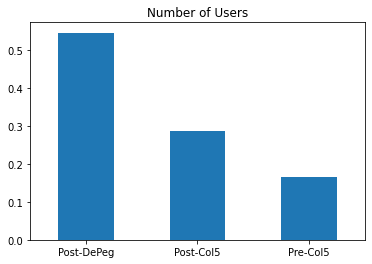

In [126]:
m.typew.value_counts(normalize=True).plot(kind='bar',rot=0, title='Number of Users')

<AxesSubplot:title={'center':'Voting Power'}, xlabel='typew'>

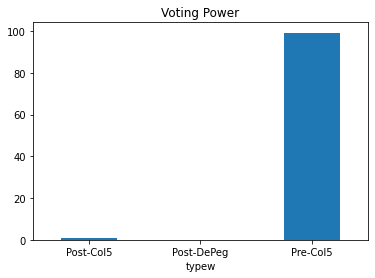

In [127]:
dfm = (m.groupby('typew').balance.sum())/1000000
(dfm/dfm.sum()*100).plot(kind='bar', rot=0, title='Voting Power')

<AxesSubplot:title={'center':'Pre-Col5'}>

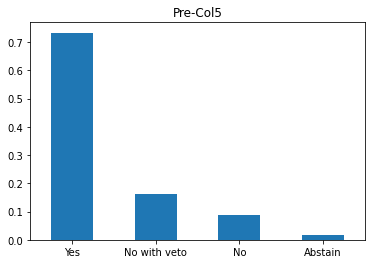

In [128]:
t='Pre-Col5'
m[m.typew==t].option.value_counts(normalize=True).plot(kind='bar', rot=0, title=t)

In [129]:
m[m.typew=='Post-DePeg'].option.value_counts(normalize=True)

Yes             0.735220
No with veto    0.206415
No              0.054843
Abstain         0.003522
Name: option, dtype: float64

In [130]:
m[m.typew=='Post-Col5'].option.value_counts(normalize=True)

Yes             0.627390
No with veto    0.235182
No              0.128107
Abstain         0.009321
Name: option, dtype: float64

In [131]:
m[m.typew=='Pre-Col5'].option.value_counts(normalize=True)

Yes             0.733224
No with veto    0.162207
No              0.088102
Abstain         0.016468
Name: option, dtype: float64